# 11장 심층 신경망 훈련

기본설정

In [54]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf ##배워보자 !!!

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

In [55]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [56]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [57]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

- 이 장에서는 먼저 그래디언트 소실 문제를 설명하고 가장 널리 알려진 해결 방법을 살펴본다.     
- 다음에는 일반 경사 하강법에 비해서 대규모 모델의 훈련 속도를 크게 높여주는 다양한 최적화 방법을 알아본다.   
- 마지막으로 대규모 신경망을 위한 규제 기법 중 널리 알려진 몇 가지를 살펴본다.

## 11.1 그래디언트 소실과 폭주 문제

- 역전파 알고리즘은 출력층에서 입력층으로 오차 그래디언트를 전파시키면서 진행한디.
- 알고리즘이 신경망의 모든 파라미터에 대한 오차 함수의 그래디언트를 계산하면, 경사 하강법 단계에서 이 그래디언트를 사용하여 각 파라미터를 수정한다.


- 하지만 알고리즘이 하위층으로 진행됨에 따라 그래디언트는 점점 작아지는 경우가 많다.
- 결국 경사 하강법이 하위층의 연결 가중치를 변경되지 않은 채로 둔다면 훈련이 좋은 솔루션에 수렴되지 않는다.
- 이를 __그래디언트 소실__이라고 한다


- 어떤 경우엔 반대 현상이 일어날 수 있다. 그래디언트가 점점 커져 여러 개의 층이 비정상적으로 큰 가중치로 갱신되면 알고리즘은 발산한다.
- 이를 __그래디언트 폭주__라고 한다.
- 주로 순환 신경망에서 나타난다.

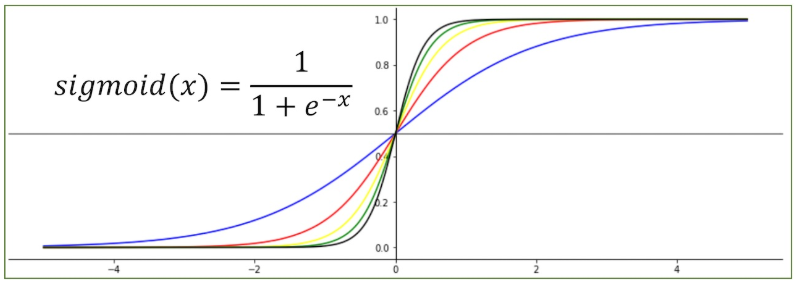

- 이는 주로 로지스틱 시그모이드 활성화 함수와 그 당싱에 가장 인기 있었던 가중치 초기화 방법의 조합때문에 일어난 다는 것을 알아냈다.


- 이 초기화 방법은 평균이 0이고 표준편차가 1인 정규분포를 사용한 무작위 초기화 방법이다.
- 즉, 이 활성화 함수와 초기화 방식을 사용했을 때 각 층에서 출력의 분산이 입력의 분산보다 더 크다는 것을 밝혀냈다.
- 신경망의 위쪽으로 갈수록 층을 지날 때마다 분산이 계속 커저 가장 높은 층에서는 활성화 함수가 0이나 1로 수렴하게 된다.
- 이는 로지스틱 함수의 평균이 0이 아니고 0.5라는 사실 때문에 더 안좋게 작용한다.


- 로지스틱 활성화 함수를 보면 입력의 절댓값이 크면 0이나 1로 수렴해서 기울기가 0에 매우 가까워지는 것을 볼 수 있다. 그래서 역전파가 될 때 사실상 신경망으로 전파시킬 그래디언트가 거의 없고 조금 있는 그래디언트는 최상위층에서부터 역전파가 진행됨에 따라 점차 약해져서 실제로 아래쪽 층에는 아무것도 도달하지 않게 된다.

## 11.1.1 세이비어 초기화와 He 초기화

 - 포인트는 '예측을 할 때는 정방향으로, 그래디언트를 역전파할 때는 역방향으로 양방향 신호가 적절하게 흘러야 한다.', '신호가 죽거나 폭주 또는 소멸하지 않아야 한다.'이다.
 
 
- 따라서, 적절한 신호가 흐르기 위해서는 각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 한다. 그리고 역방향에서 층을 통과하기 전과 후의 그래디언트 분산이 동일해야 한다.
- 사실 층의 입력과 출력 연결 개수가 같지 않다면 이 두 가지를 보장할 수 없다. 하지만 실전에서 매우 잘 작동한다고 입증된 대안이 있다.


- 연결 가중치를 [식 11-1]에 기술한 방식대로 무작위로 초기화하는 것이다. 이 식에서 $n_{inputs}$와 $n_{outputs}$는 가중치를 초기화하려는 층의 입력과 출력 연결의 개수이다(또는 fan-in과 fan-out으로 부른다). 이 초기화 전략을 세이비어 초기화(Xavier initialization) 또는 글로럿 초기화(Glorot initialization)이라고 한다.

[식 11-1] 세이비어 초기화(로지스틱 활성화 함수를 사용했을 때)  



$$평균이\ 0이고\ 표준편차 \sigma = \sqrt{\frac{2}{ n_{inputs} + n_{outputs}} }인\ 정규분포$$

$$또는 r = \sqrt{\frac{6}{ n_{inputs} + n_{outputs}} }\ 일\ 때\ -r과\ +r\ 사이의\ 균등분포$$

- 입력의 연결 개수가 대략 출력의 연결 개수와 비슷하면 더 간단한 공식을 사용한다(예를 들면 $\sigma = \frac{1}{\sqrt{n_{inputs}}}$또는 $r = \frac{\sqrt{3}}{\sqrt{n_{outputs}}}$).
- 10장에서는 기본 세이비어 초기화 전략을 사용했다. 이는 훈련 속도를 상당히 높일 수 있다.



- ReLU 활성화 함수를 위한 초기화 전력을 He 초기화(He initialization)라고 부르기도 한다.

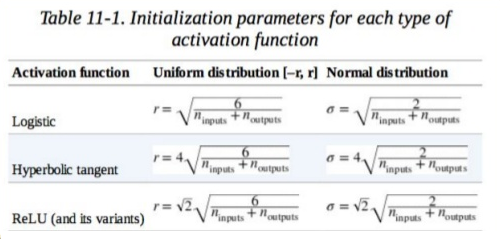

- (10장에서 소개한) tf.layer.dense() 함수는 기본적으로 (균등분포로) 세이비어 초기화를 사용한다. 이를 variance_scaling_initializer() 함수를 사용하여 다음과 같이 He 초기화 방식으로 바꿀 수 있다.

In [58]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [59]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                         kernel_initializer=he_init, name="hidden1")

variance_scaling_initializer() 함수는 기본값이 각각 factor=2.0, mode='FAN_IN', uniform=False인 세 개의 주요 매개변수를 가지고 있다. 정규분포일 경우에는 $\sqrt{(factor \times 2)/ n}$를 상요하고 균등분포일 경우에는 $\sqrt{(factor \times 6)/ n}$을 사용한다. 여기서 mode='FAN_AVG', factor=1.0을 적용하면 [table 11-1]의 로지스틱 공식과 같다. 사실 세이비어 초기화도 variance_scaling_initializer() 함수를 사용한다. [table 11-1]과 한 가지 다른 점은 텐서플로는 앞 장에서 우리가 직접 초기화했을 때처럼 절단 정규분포를 사용하기 때문에 이에 대한 보정을 반영하여 $\sqrt{(1.3 \times factor \times 2)/ n}$으로 계산합니다.

In [60]:
help(tf.variance_scaling_initializer)

Help on class VarianceScaling in module tensorflow.python.ops.init_ops:

class VarianceScaling(Initializer)
 |  Initializer capable of adapting its scale to the shape of weights tensors.
 |  
 |  With `distribution="normal"`, samples are drawn from a truncated normal
 |  distribution centered on zero, with `stddev = sqrt(scale / n)`
 |  where n is:
 |    - number of input units in the weight tensor, if mode = "fan_in"
 |    - number of output units, if mode = "fan_out"
 |    - average of the numbers of input and output units, if mode = "fan_avg"
 |  
 |  With `distribution="uniform"`, samples are drawn from a uniform distribution
 |  within [-limit, limit], with `limit = sqrt(3 * scale / n)`.
 |  
 |  Args:
 |    scale: Scaling factor (positive float).
 |    mode: One of "fan_in", "fan_out", "fan_avg".
 |    distribution: Random distribution to use. One of "normal", "uniform".
 |    seed: A Python integer. Used to create random seeds. See
 |      @{tf.set_random_seed}
 |      for behav

## 11.1.2 수렴하지 않는 활성화 함수

- 활성화 함수를 잘못 선택하면 자칫 그래디언트의 소실이나 폭주로 이어질 수 있다.
- ReLU 함수는 특정 양숫값에 수렴하지 않는다는 장점이 있다(계산도 빠르다).

- 하지만 ReLU 함수는 완벽하지 않다. __죽은 ReLU__로 알려진 문제가 있다.
- 훈련하는 동안 일부 뉴런이 0이외의 값을 출력하지 않는다는 의미로 죽었다고 말한다.
- 어떤 경우에는, 특히 큰 학습률을 사용하면 신경망의 뉴런 절반이 죽어 있기도 한다.
- 훈련 도중 뉴런의 가중치가 바뀌어 가중치 합이 음수가 되면 그다음부터 0을 출력하기 시작한다. ReLU 함수는 입력이 음수면 그래디언트가 0이 되기 때문에 이런 일이 생기면 뉴런이 다시 살아나기 어렵다.

- 이 문제를 해결하기 위해 __LeakyReLU__ 같은 ReLU 함수의 변종을 사용한다.
- 이 함수는 $LearkyReLU_{\alpha}(z) = max(\alpha z, z)$로 정의된다. 하이퍼파라미터 $\alpha$가 이 함수가 '새는(leaky)' 정도를 결정한다. 새는 정도란 $z <0$일 때 이 함수의 기울기이며, 일반적으로 $0.01$로 설정한다. 이 작은 기울기가 LeakyReLU를 절대 죽지 않게 만들어준다.


- 최근 한 논문에서 여러 ReLU 함수의 변종을 비교해 얻은 결론 하나는 LeakyReLU가 ReLU보다 항상 성능이 높다는 것이다. 사실 $\alpha = 0.2$로 하는 것이 $\alpha=0.01$보다 더 나은 성능을 내는 것으로 보인다
- 이 논문은 훈련하는 동안 주어진 범위에서 $\alpha$를 무작위로 선택하고 테스트 시에는 평균을 사용하는 __RReLU(randomized leaky ReLU)__도 평가했다. 이 함수도 꽤 잘 작동했으며 (훈련 세트의 과대적합 위험을 줄이는) 규제의 역활을 하는 것처럼 보였다.
- 마지막으로 $\alpha$가 훈련하는 동안 학습되는 __PReLU(parametric leark ReLU)__도 비교했다. 이 함수는 대규모 이미지 데이터셋에서는 ReLU보다 성능이 크게 앞섰지만, 소규모 데이터셋에서는 훈련 세트에 과대적합될 위험이 있다.

- 또 하나 중요한 함수는 2015년의 한 논문에서 제안한 __ELU(exponential linear unit)__라는 새로운 ㅘㄹ성하 함수이다. 이 함수는 실험에서 다른 모든 ReLU 변종의 성능을 앞질렀다. 훈련 시간이 줄고 신경망의 테스트 세트 성능도 더 높았다. 

$$ELU_{\alpha}(z) =  \begin{cases}
\alpha (exp(z) - 1 , &z < 0\mbox{일 때} \\
z, &z\geq 0 \mbox{일 때}
\end{cases}$$

이 함수는 몇 가지를 제외하고는 ReLU와 매우 비슷하다.

- 첫째,  $z<0$일 때 음숫값이 들어오므로 활성화 함수의 평균 출력이 0에 더 가까워진다. 이는 앞서 이야기한 그래디언트 소실 문제를 완화해준다. 하이퍼파라미터 $\alpha$는 $z$가 큰 음숫값일 때 ELU가 수렴할 값을 정의한다. 보통 1로 설정하지만 필요하면 다른 하이퍼파라미터처럼 원하는 값으로 변경할 수 있다.
- 둘째, $z<0$이어도 그래디언트가 0이 아니므로 죽은 뉴런을 만들지 않는다.
- 셋째, $\alpha = 1$일 때 이 함수는 $z = 0$ 에서 급격히 변동하지 않고 $z=0$을 포함해 모든 구간에서 매끄러워 경사 하강법의 속도를 높여준다.

ELU 활성화 함수의 주요 단점은 ReLU나 그 변종들보다 계산이 느리다는 것이다. 훈련하는 동안에는 수렴 속도가 빠르기 때문에 상쇄되지만 테스트 시에는 ELU 신경망이 ReLU 신경망보다 느릴 것이다.

- 일반적으로 ELU > LeakyReLU (그리고 변종들) > ReLU > tanh > 로지스틱 순으로 사용한다. 실행 속도가 중요하다면 LeakyReLU가 ELU보다 나을 수 있다.
- 하이퍼파라미터를 더 추가하고 싶지 않다면 앞서 추천한 기본 $\alpha$ 값을 사용한다(LeakyReLU는 0.01, ELU는 1). 
- 시간과 컴퓨팅 파워가 충분하다면 교차 검증을 사용해 여러 활성화 함수를 평가해볼 수 있다. 특히 신경망이 과대적합되었다면 RReLU, 훈련 세트가 아주 크다면 PReLU를 포함시키면 좋다

- 텐서플로는 신경망에 사용할 수 있는 elu() 함수를 제공한다.

In [61]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [62]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name='hidden1')

LeakyReLU는 텐서플로가 기본으로 제공하지는 않지만, 다음처럼 간단히 만들어 사용할 수 있다.

In [63]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [64]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

## 11.1.3 배치 정규화

그래디언트 소실과 폭주 문제를 해결하기 위한 배치 정규화(BN) 기법이 있다.

- 문제는 훈련하는 동안 이전 층의 파라미터가 변함에 따라 각 층에 들어오는 입력의 분포가 변호되는 것이다.


- 이 기법은 각 층에서 활성화 함수를 통과하기 전에 모델에 연산을 하나 추가한다.
- 입력 데이터의 평균을 0으로 만들고 정규화한 다음, 각 층에서 두 개의 새로운 파라미터로 결괏값의 스케일을 조정하고 이동시킨다(하나는 스케일 조정을 위해, 다른 하나는 이동을 위해 필요하다). 다시 말해 이 연산으로 모델이 층마다 입력 데이터의 최적 스케일과 평균을 학습한다.


- 입력 데이터의 평균을 0으로 만들고 정규화하려면 알고리즘은 평균과 표준편차를 추정해야하 한다. 이를 위해 현재 미니배치에서 입력의 평균과 표준편차를 평가한다.

[식 11-3] 배치 정규화 알고리즘
1. $\displaystyle{\mu_B = \frac{1}{m_s}\sum^{m_s}_{i=1}x^{(i)}    }$  
2. $\displaystyle{\sigma^2_B = \frac{1}{m_s}\sum^{m_s}_{i=1}(x^{(i)} - \mu_s)^2          }$
3. $\displaystyle{\hat{x}^{(i)} = \frac{x^{(i)} - \mu_s}{\sqrt{\sigma^2_B + \epsilon}}          }$
4. $\displaystyle{z^{(i)} = \gamma\hat{x}^{(i)} + \beta          }$


- $\mu_B$는 미니배치 $B$에 대해 평가하여 관측한 평균이다.
- $\sigma_s$도 미니배치에 대해 평가하여 관측한 표준편차다.
- $m_s$는 미니배치에 있는 샘플 수다.
- $\hat{x}^{(i)}$는 평균이 0이고 정규화된 입력이다.
- $\gamma$는 층의 스케일 파라미터다.
- $\beta$는 층의 이동(편향) 파라미터다.
- $\epsilon$은 분모가 0이 되는 것을 막기 위한 작은 숫자(전형적으로 $10^{-5}$다. 이를 안전을 위한 항이라고 한다
- $z^{(i)}$는 BN 연산의 출력이다. 즉, 입력의 스케일을 조정하고 이동시킨 것이다.

테스트할 때는 평균과 표준편차를 계산할 미니배치가 없으니 전체 훈련 세트의 평균과 표준편차를 대신 사용한다. 이 값들은 훈련 과정에서 이동 평균을 사용하여 효율적으로 계산되므로, 전체적으로 보면 배치 정규화된 층마다 $\gamma$(스케일), $\beta$(이동) $\mu$(평균) $\sigma$(표준편차) 네 개의 파라미터가 학습된다. 

- 이 기법으로 논문에서 실험했던 모든 심층 신경망의 성능이 크게 향상되었다. tanh나 로지스틱 활성화 함수 같이 수렴되는 활성화 함수를 사용하더라도 그래디언트 소실 문제가 크게 감소되었다. 또한 네트워크가 가중치 초기화에 훨씬 덜 민감해진다. 그리고 훨씬 큰 학습률을 사용할 수 있어 학습 속도를 크게 개선해준다. 마지막으로 배치 정규화는 규제와 같은 역할을 하여 다른 규제 기법의 필요성을 줄여준다.


- 그러나 (첫 번째 은닉층에 배치 정규화를 적용하면 입력 데이터를 정규화할 필요가 없어지지만) 배치 정규화는 모델의 복잡도를 키운다. 실행 시간 면에서도 손해가 있다.

- 예측이 빨라야 한다면 배치 정규화를 사용하기 전에 ELU + He 초기화만으로 얼마나 잘 수행되는지 확인해보는 것이 좋다.

#### 텐서플로를 사용해 배치 정규화 구현하기

- 입력값을 중앙에 정렬하고 정규화해주는 tf.nn.batch_normalization() 함수가 있지만, 다른 것들을 다 해주는 tf.layers.batch_normalization() 함수를 사용하는 편이 좋다

In [65]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training') ## 입력이 안되면, default 값이 나옴

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                      momentum=0.9)

코드를 차례대로 살펴보자.  
training은 훈련하는 동안에는 True로 그 외에는 False로 설정한다. 이를 이용하여 tf.layers.batch_normalization() 함수가 (훈련할 때) 현재 미니배치의 평균과 표준편차를 사용할지 또는 (테스트할 때) 전체 훈련 세트에 대한 평균과 표준편차를 사용할지 지정한다.  

그다음에는 완전 연결 층과 배치 정규화 층이 번갈아 나온다. 앞 장에서 한 것처럼 tf.layers.dense()를 사용해 완전 연결 층을 생성한다. 배치 정규화 층 이후에 활성화 함수를 적용하기 때문에 완전 연결 층에는 어떤 활성화 함수도 지정하지 않는다. 그리고 training, momentum 매개변수와 함께 tf.layers.batch_normalization() 함수를 사용해 배치 정규화 층을 만든다. BN 알고리즘은 지수 감소를 사용해 이동 평균을 계산한다.
$$\hat{\nu} \leftarrow \hat{\nu}\times momentum + \nu \times(1- momentum)$$
적절한 모맨텀 값은 일반적으로 1에 가깝다. 데이터셋이 크고 미니배치가 작을 경우 9를 더 넣어 1에 더 가깝게 한다.

- 이 코드는 같은 배치 정규화 매개변수가 계속 반복되기 때문에 코드 중복이 많다. 이런 중복을 피하기 위해 파이썬의 (표준 라이브러리에 포함된) functools 모듈 안에 있는 partial() 함수를 사용할 수 있다. 이 함수는 어떤 함수를 감싼 래퍼 함수를 생성하며 매개변수의 기본값을 지정할 수 있도록 도와준다

In [66]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
training = tf.placeholder_with_default(False, shape=(), name='training')

from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization, 
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name='hidden1')
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name='hidden2')
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

작은 예제라서 아주 많이 나아 보이진 않지만, 예를 들어 10개의 층 모두에 같은 활성화 함수, 초기화, 규제 등을 사용한다면 이런 기교가 훨씬 읽기 쉬운 코드를 만들어 줄 것이다.

실제로 실행해보자!!

In [67]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

구성 단계: 비용 함수를 정의하고 옵티마이저를 생성해서 비용함수를 최소화하도록 함수를 호출한 다음, 평가 연산을 정의하고 Saver 객체를 만드는 과정

실행 단계  
1. 훈련하는 동안에는 batch_normalization() 함수에 의존하는 어떤 연산을 수행할 때마다 training 플레이스홀더를 True로 설정해야한다.
2. batch_normalization() 함수는 이동 평균을 갱신하기 위해 매 훈련 단계에서 평가할 몇 개의 연산을 만든다(이 이동 평균이 훈련 세트의 평균과 표준편차를 계산하기 위해 필요하다). 이 연산은 자동으로 UPDATE_OPS 컬렉션에 추가되므로 우리가 할 일은 컬렉션에서 이 연산들을 뽑아내어 훈련이 반복될 때마다 실행해주면 된다.

In [68]:
n_epochs = 20
batch_size = 200

In [69]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops], ##extra_update_ops는 리스트인데 sess.run안에 [[a,b], [c]] 식의 구조가 있다면 [[1,2], 3]으로 나온다
                    feed_dict = {training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)
    
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.9042
1 검증 세트 정확도: 0.928
2 검증 세트 정확도: 0.9374
3 검증 세트 정확도: 0.9474
4 검증 세트 정확도: 0.9532
5 검증 세트 정확도: 0.9572
6 검증 세트 정확도: 0.9626
7 검증 세트 정확도: 0.9628
8 검증 세트 정확도: 0.9664
9 검증 세트 정확도: 0.968
10 검증 세트 정확도: 0.9694
11 검증 세트 정확도: 0.9696
12 검증 세트 정확도: 0.971
13 검증 세트 정확도: 0.971
14 검증 세트 정확도: 0.9728
15 검증 세트 정확도: 0.9734
16 검증 세트 정확도: 0.9728
17 검증 세트 정확도: 0.975
18 검증 세트 정확도: 0.9752
19 검증 세트 정확도: 0.976


이런 얕은 신경망에서는 배치 정규화와 ELU가 큰 효과를 내지 못한다. 대부분 심층 신경망에서 빛을 발한다.

In [70]:
a = tf.constant(10)
b = tf.constant(20)
f = a + b

In [71]:
with tf.Session() as sess:
    sess.run([a,b])
    print(sess.run([f, [a,b]]))

[30, [10, 20]]


## 11.1.4 그래디언트 클리핑

- 그래디언트 폭주 문제를 줄이는 쉬운 방법은 역전파될 때 일정 임곗값을 넘어서지 못하게 그래디언트를 그냥 단순히 잘라내는 것이다. 이를 __그래디언트 클리핑이__라고 한다. 일반적으로 배치 정규화를 선호하지만 그래디언트 클리핑이 무엇인지 또 어떻게 구현하는지 알아두면 유용하다.

- 텐서플로에서 옵티마이저의 minimize() 함수는 그래디언트의 계산과 적용 두 가지를 모두 처리한다. 그래서 이 함수를 대신하려면 옵티마이저의 compute_gradients() 메서드를 먼저 호출하고, 그다음에 clip_by_value() 함수를 사용해 그래디언트를 클리핑하는 연산을 생성한다. 마지막으로 옵티마이저의 apply_gradients() 메서드를 사용해 클리핑된 그래디언트를 적용하는 연산을 만든다.

In [72]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [73]:
learning_rate = 0.01

In [74]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) 
              for grad, var in grads_and_vars] ## var은 변수들
training_op = optimizer.apply_gradients(capped_gvs)

In [75]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [76]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [77]:
n_epochs = 20
batch_size = 200

In [78]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.2876
1 검증 세트 정확도: 0.794
2 검증 세트 정확도: 0.8798
3 검증 세트 정확도: 0.9056
4 검증 세트 정확도: 0.9162
5 검증 세트 정확도: 0.9218
6 검증 세트 정확도: 0.9292
7 검증 세트 정확도: 0.9356
8 검증 세트 정확도: 0.938
9 검증 세트 정확도: 0.9416
10 검증 세트 정확도: 0.9456
11 검증 세트 정확도: 0.947
12 검증 세트 정확도: 0.9476
13 검증 세트 정확도: 0.9532
14 검증 세트 정확도: 0.9564
15 검증 세트 정확도: 0.9566
16 검증 세트 정확도: 0.9576
17 검증 세트 정확도: 0.9588
18 검증 세트 정확도: 0.9622
19 검증 세트 정확도: 0.9612


- 그러고 나서 이전과 마찬가지로 매 훈련 단계마다 training_op을 실행해준다. 
- 이 코드는 그래디언트를 계산하고 그것을 -1.0과 1.0 사이로 클리핑해서 적용한다.
- 임곗값은 하이퍼파라미터이므로 튜닝의 대상이다

# 11.2 미리 훈련된 층 재사용하기  

- 일반적으로 아주 큰 규모의 DNN을 훈련시킬 때, 해결하려는 것과 비슷한 유형의 문제를 처리한 신경망이 이미 있는지 찾아보고 그런 다음 그 신경망의 하위층을 재사용하는 것이 좋다. 이를 __전이 학습__이라고 한다.

## 11.2.1 텐서플로 모델 재사용하기

- 원본 모델이 텐서플로를 사용해 훈련되었다면 간단하게 바로 복원해서 새로운 작업에 훈련시킬 수 있다.
- 9장에서 언급한 것처럼 import_meta_graph() 함수를 사용하여 기본 그래프에 연산을 적재할 수 있다. 이 함순느 Saver 객체를 반환하는데, 나중에 저장된 모델 파라미터를 불러올 때 사용한다.
- 그다음에는 훈련 대상인 연산과 텐서를 직접 지정해야 한다. 이를 위해 그래프의 get_operation_by_name()과 get_tensor_by_name() 메서드를 사용한다. 텐서 이름은 연산 이름 뒤에 :0을 붙인다.
- 미리 훈련된 모델이 잘 문서화되어 있지 않으면 필요한 연산의 이름을 찾기 위해 그래프를 뒤져야 한다. 이런 경우 텐서보드를 사용하여 그래프를 탐색하거나(9장에서 언급한 것과 같이 FileWriter를 사용해 그래프를 저장해야 한다) get_operations() 메서드를 사용해 모든 연산의 리스트를 볼 수 있다.

In [79]:
reset_graph()

In [80]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta") ##그래프가 소환됨

In [81]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

In [82]:
show_graph(tf.get_default_graph().as_graph_def())

In [83]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

- 원본 모델을 직접 만들었다면 다른 사람들이 모델을 쉽게 재사용할 수 있도록 연산에 명확한 이름을 사용하고 문서화해놓아야 한다.
- 또 다른 방법은 다른 사람을 위해 중요한 연산들을 모아놓은 컬렉션을 만드는 것이다.


In [84]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

In [85]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

세션을 시작하고 모델을 복원하여 준비된 훈련 데이터로 훈련을 계속할 수 있다.

In [86]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") ## 모델 복원!

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


실제 테스트

In [87]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") ## 모델 복원!
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)
    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.9634
1 검증 세트 정확도: 0.963
2 검증 세트 정확도: 0.9654
3 검증 세트 정확도: 0.9648
4 검증 세트 정확도: 0.9644
5 검증 세트 정확도: 0.9648
6 검증 세트 정확도: 0.9688
7 검증 세트 정확도: 0.9684
8 검증 세트 정확도: 0.9684
9 검증 세트 정확도: 0.9686
10 검증 세트 정확도: 0.9706
11 검증 세트 정확도: 0.9714
12 검증 세트 정확도: 0.967
13 검증 세트 정확도: 0.9696
14 검증 세트 정확도: 0.9708
15 검증 세트 정확도: 0.9722
16 검증 세트 정확도: 0.972
17 검증 세트 정확도: 0.9712
18 검증 세트 정확도: 0.9714
19 검증 세트 정확도: 0.971


- 만약 원본 그래프를 만든 파이썬 코드에 접근할 수 있다면 import_meta_graph() 대신 그것을 사용할 수 있다.

In [88]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

그 다음 훈련을 계속할 수 있다.

In [89]:
with tf.Session() as sess:
    saver.restore(sess, "./my_new_model_final.ckpt") ## 모델 복원!!

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_newnew_model_final.ckpt")


INFO:tensorflow:Restoring parameters from ./my_new_model_final.ckpt
0 검증 세트 정확도: 0.973
1 검증 세트 정확도: 0.973
2 검증 세트 정확도: 0.9736
3 검증 세트 정확도: 0.9742
4 검증 세트 정확도: 0.9702
5 검증 세트 정확도: 0.9748
6 검증 세트 정확도: 0.9746
7 검증 세트 정확도: 0.974
8 검증 세트 정확도: 0.9752
9 검증 세트 정확도: 0.9754
10 검증 세트 정확도: 0.9742
11 검증 세트 정확도: 0.9764
12 검증 세트 정확도: 0.9728
13 검증 세트 정확도: 0.974
14 검증 세트 정확도: 0.9758
15 검증 세트 정확도: 0.9752
16 검증 세트 정확도: 0.9756
17 검증 세트 정확도: 0.9752
18 검증 세트 정확도: 0.9746
19 검증 세트 정확도: 0.9748


- 일반적으로 원본 모델의 일부분, 특히 하위층만 재사용하는 경우가 많다. 
- import_meta_graph() 함수를 사용해 그래프를 복원하면 원본 그래프 전체를 적재한다.


- 필요한 부분만 가져오기 

In [90]:
reset_graph()

n_hidden4 = 20 # 새 층
n_outputs = 10 # 새 층

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name='loss')
    
with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [91]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)
        
    saver_path = new_saver.save(sess, "./my_new_model_final.ckpt")


INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.8982
1 검증 세트 정확도: 0.9276
2 검증 세트 정확도: 0.9374
3 검증 세트 정확도: 0.9444
4 검증 세트 정확도: 0.9502
5 검증 세트 정확도: 0.9526
6 검증 세트 정확도: 0.9568
7 검증 세트 정확도: 0.9586
8 검증 세트 정확도: 0.9574
9 검증 세트 정확도: 0.963
10 검증 세트 정확도: 0.9636
11 검증 세트 정확도: 0.9642
12 검증 세트 정확도: 0.9602
13 검증 세트 정확도: 0.9668
14 검증 세트 정확도: 0.9662
15 검증 세트 정확도: 0.967
16 검증 세트 정확도: 0.9676
17 검증 세트 정확도: 0.9668
18 검증 세트 정확도: 0.9674
19 검증 세트 정확도: 0.9686


원본 모델을 만든 파이썬 코드에 접근할 수 있다면 필요한 부분만 재사용하고 나머지는 버릴 수 있습니다.

In [100]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # 재사용
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

이전에 학습된 모델을 복원하기 위해(복원할 변수 리스트를 전달한다. 그렇지 않으면 그래프와 맞지 않는다고 에러를 낼 것) Saver 객체를 하나 만들고 훈련이 끝난 후 새로운 모델을 저장하기 위해 또 다른 Saver 객체를 만들어야 한다.

In [102]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                              scope="hidden[1]") ## 정규표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_new_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)
    
    save_path = saver.save(sess, "./my_newnew_model_final.ckpt")
        

INFO:tensorflow:Restoring parameters from ./my_new_model_final.ckpt
0 검증 세트 정확도: 0.8904
1 검증 세트 정확도: 0.9246
2 검증 세트 정확도: 0.9418
3 검증 세트 정확도: 0.949
4 검증 세트 정확도: 0.953
5 검증 세트 정확도: 0.9522
6 검증 세트 정확도: 0.9596
7 검증 세트 정확도: 0.9608
8 검증 세트 정확도: 0.9606
9 검증 세트 정확도: 0.9644
10 검증 세트 정확도: 0.9636
11 검증 세트 정확도: 0.966
12 검증 세트 정확도: 0.9664
13 검증 세트 정확도: 0.9682
14 검증 세트 정확도: 0.968
15 검증 세트 정확도: 0.968
16 검증 세트 정확도: 0.969
17 검증 세트 정확도: 0.97
18 검증 세트 정확도: 0.97
19 검증 세트 정확도: 0.9716


## 11.2.2 다른 프레임워크의 모델 재사용하기  

(나중에)

## 11.2.3 신경망의 하위층을 학습에서 제외하기  

- 일반적으로 새로운 DNN을 훈련시킬 때 재사용되는 층들의 가중치를 '동결'하는 것이 좋다.
- 한 가지 방법은 하위츠으이 변수를 제외하고 훈련시킬 변수 목록을 옵티마이저에 전달하는 것이다.

In [118]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # 재사용
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [119]:
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [120]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                              scope='hidden[123]') ##정규 표현식
restore_saver = tf.train.Saver(reuse_vars) ## 1-2층 복원

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.8952
1 검증 세트 정확도: 0.9302
2 검증 세트 정확도: 0.94
3 검증 세트 정확도: 0.9442
4 검증 세트 정확도: 0.9478
5 검증 세트 정확도: 0.9502
6 검증 세트 정확도: 0.9508
7 검증 세트 정확도: 0.9536
8 검증 세트 정확도: 0.9554
9 검증 세트 정확도: 0.9566
10 검증 세트 정확도: 0.956
11 검증 세트 정확도: 0.9566
12 검증 세트 정확도: 0.957
13 검증 세트 정확도: 0.9572
14 검증 세트 정확도: 0.9588
15 검증 세트 정확도: 0.9578
16 검증 세트 정확도: 0.9578
17 검증 세트 정확도: 0.9598
18 검증 세트 정확도: 0.9588
19 검증 세트 정확도: 0.9604


- 또 다른 방법은 그래프에 stop_gradient() 층을 추가하는 것이다.

In [114]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [115]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # 동결층 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # 동결층 재사용
    hidden2_stop = tf.stop_gradient(hidden2) ###########추가!!!!!!!
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # 동결하지 않고 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # 새로 만듦!

In [116]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [117]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규 표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.9018
1 검증 세트 정확도: 0.9306
2 검증 세트 정확도: 0.9432
3 검증 세트 정확도: 0.9476
4 검증 세트 정확도: 0.9516
5 검증 세트 정확도: 0.9522
6 검증 세트 정확도: 0.9522
7 검증 세트 정확도: 0.9554
8 검증 세트 정확도: 0.9552
9 검증 세트 정확도: 0.9558
10 검증 세트 정확도: 0.9572
11 검증 세트 정확도: 0.955
12 검증 세트 정확도: 0.9574
13 검증 세트 정확도: 0.9578
14 검증 세트 정확도: 0.9584
15 검증 세트 정확도: 0.9574
16 검증 세트 정확도: 0.9564
17 검증 세트 정확도: 0.9576
18 검증 세트 정확도: 0.9592
19 검증 세트 정확도: 0.9582


## 11.2.4 동결된 층 캐싱하기  

- 동결된 층은 변하지 않기 때무에 각 훈련 샘플에 대해 가장 위쪽의 동결된 층에서 나온 출력을 캐싱하는 것이 가능하다.
- 전체 데이터셋에 대한 훈련이 여러 번 반복되기 때문에 훈련 샘플 마다 동결된 층을 한 번만 거친다면(에포크마다 한 번씩이 아니라) 학습 속도를 크게 높일 수 있다.

In [150]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # 동결층 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # 동결층 재사용 & 캐싱
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # 동결하지 않고 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [151]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규 표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [152]:
n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid})
    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2: hidden2_batch,
                                            y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid,
                                                y: y_valid})
        print(epoch, "검증 세트 정확도: ", accuracy_val)
        
    save_path = saver.save(sess, "./my_new_model_final.ckpt")
            

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도:  0.9018
1 검증 세트 정확도:  0.9306
2 검증 세트 정확도:  0.9432
3 검증 세트 정확도:  0.9476
4 검증 세트 정확도:  0.9516
5 검증 세트 정확도:  0.9522
6 검증 세트 정확도:  0.9522
7 검증 세트 정확도:  0.9554
8 검증 세트 정확도:  0.9552
9 검증 세트 정확도:  0.9558
10 검증 세트 정확도:  0.9572
11 검증 세트 정확도:  0.955
12 검증 세트 정확도:  0.9574
13 검증 세트 정확도:  0.9578
14 검증 세트 정확도:  0.9584
15 검증 세트 정확도:  0.9574
16 검증 세트 정확도:  0.9564
17 검증 세트 정확도:  0.9576
18 검증 세트 정확도:  0.9592
19 검증 세트 정확도:  0.9582


## 11.2.5 상위층을 변경, 삭제, 대체하기  

- 원본 모델의 출력층은 새로운 작업에는 거의 쓸모가 없다.
- 비슷하게 원본 모델의 상위층은 하위층보다는 덜 유용하다.
- 따라서 재사용할 적절한 층의 개수를 알아야 한다.


- 먼저 복사한 모든 층을 동결한다. 그다음에 모델을 훈련시키고 얼마나 성능이 나오는지 지켜본다. 그 후 가장 위쪽의 은닉층 한 개나 두 개의 동결을 해제해서 역전파로 가중치가 변경되게 하고 성능이 향상되는지 확인한다. 훈련 데이터가 많을수록 많은 층을 동결 해제할 수 있다.
- 그래도 좋은 성능을 얻을 수 없고 훈련 데이터가 적다면 가장 위쪽의 은닉층(들)을 제거하고 남은 은닉층을 다시 모두 동결한다. 재사용에 적절한 층의 개수를 찾을 때까지 반복한다. 
- 훈련 데이터가 충분하다면 최상위 은닉층을 버리는 대신 바꿔볼 수 있으며, 심지어 은닉층을 더 추가할 수도 있다.

## 11.2.6 모델 저장소  

인터넷에 모델 저장소가 있음

## 11.2.7 비지도 사전훈련  

레이블된 훈련 데이터가 많지 않은 복잡한 문제가 있을 때, 비지도 사전훈련을 해볼 수 있다. 

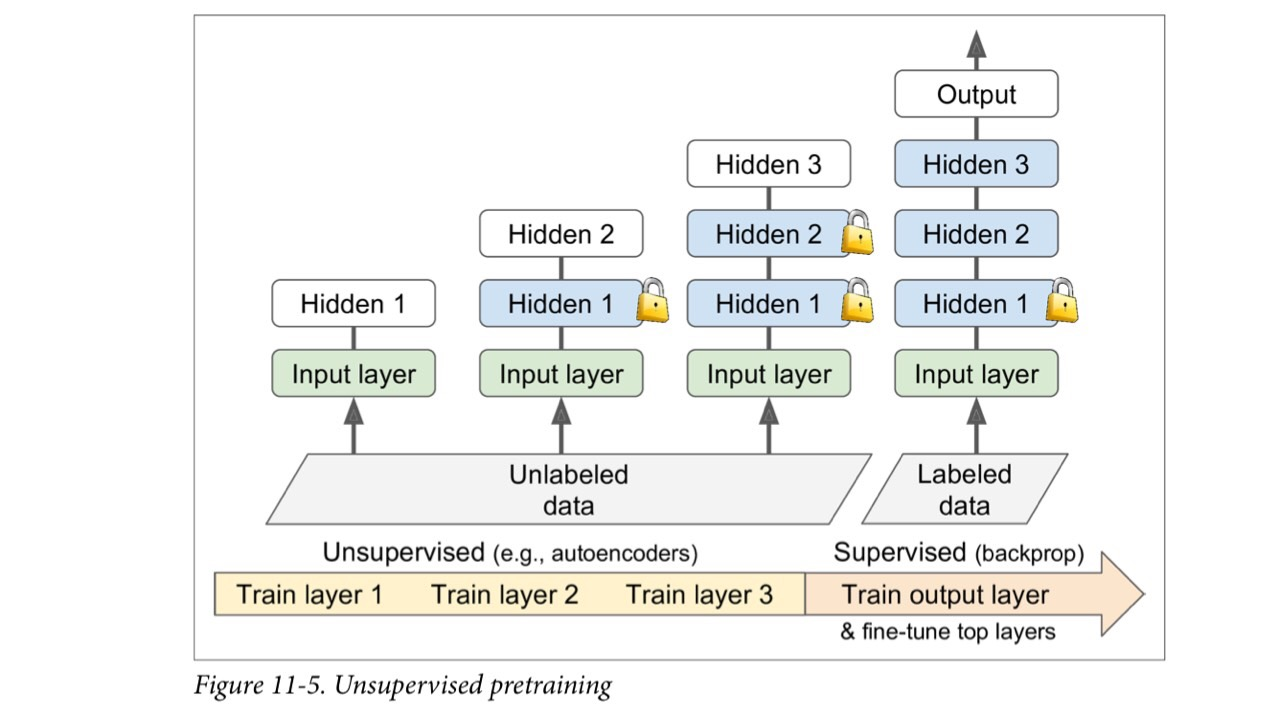

- 풀어야 할 문제가 복잡하고 재사용할 수 있는 비슷한 모델이 없으며 레이블된 훈련 데이터가 적고 그렇지 않은 데이터는 많을 때는 (오늘날엔 일반적으로 RBM보다 오토인코더를 사용한) 비지도 사전훈련이 좋은 선택이다.

## 11.2.8 보조 작업으로 사전훈련  

- 마지막 선택사항은 레이블된 훈련 데이터를 쉽게 얻거나 생성할 수 있는 보조 작업에 첫 번째 신경망을 훈련시키는 것이다
- 그리고 이 신경망의 하위층을 실제 작업을 위해 재사용한다.
- 첫 번째 신경망의 하위층은 두 번째 신경망에 재사용될 수 있는 특성 추출기를 학습하게 된다.


- 1. 훈련 샘플 전체를 '좋은 샘플'로 레이블하고 좋은 샘플을 오염시켜 새로운 훈련 샘플을 생성하여 '나쁜 샘플'로 레이블한다. 그런 다음 좋은 샘플과 나쁜 샘플을 분류하는 첫 번째 신경망을 훈련시킬 수 있다.
- 2. 또 다른 접근 방식은 첫 번째 신경망이 각 훈련 샘플에 대해 점수를 출력하도록 훈련시키고 좋은 샘플의 점수가 나쁜 샘플의 점수보다 일정 마진 이상 더 크게 만드는 비용 함수를 사용하는 것이다. 이를 __최대 마진 학습__이라고 한다.